In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from IPython.display import clear_output
import time

images = np.load('/Users/abhilash/Documents/ml_project/images.npy')
labels = np.load('/Users/abhilash/Documents/ml_project/labels.npy')
num_images,height,width = np.shape(images)
images = images.astype(float)
HEIGHT = images.shape[1]
WIDTH = images.shape[2]
images = np.reshape(images,(num_images,height*width))

labels = labels.astype(int)


x_valid = images[45000:50000][:]
y_valid = labels[45000:50000]


x_train = images[0:45000][:]
y_train = labels[0:45000]


train_seqs = x_train
train_labels = y_train

val_seqs = x_valid
val_labels = y_valid


#constants
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 2000
batch_size = 128;


In [2]:
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

In [3]:
model = TooSimpleConvNN()

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
def train(batch_size):
    #model.train() puts our model in train mode, which can require different behaviour than eval mode (for example
    #in the case of dropout
    #model.train()
    #i is a 1 dimensional array with shape[batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [6]:
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

In [7]:
def approx_val_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

In [8]:
def accuracy(y,y_hat):
    correct = np.count_nonzero(y_hat.data.numpy()==y.data.numpy())
    return correct/y.data.shape[0]

In [9]:
#time
t = time.time()
#training
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))

elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 20.90 19.66
   100 55.00 55.96
   200 65.60 65.58
   300 68.10 66.68
   400 68.30 70.94
   500 74.10 74.44
   600 73.90 74.92
   700 77.50 78.98
   800 76.00 77.00
   900 76.80 78.26
  1000 79.10 79.26
  1100 79.20 80.68
  1200 81.50 80.86
  1300 80.20 80.28
  1400 80.00 78.96
  1500 81.00 79.94
  1600 82.70 81.38
  1700 81.50 82.76
  1800 80.10 81.32
  1900 80.40 80.34
Total training time approx. = 239.90235805511475 secs


average accuracy =  0.73095


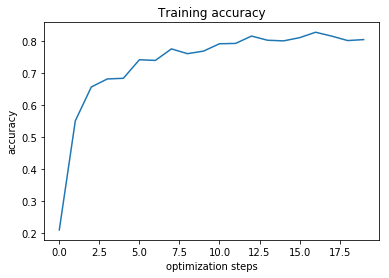

In [10]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.7341


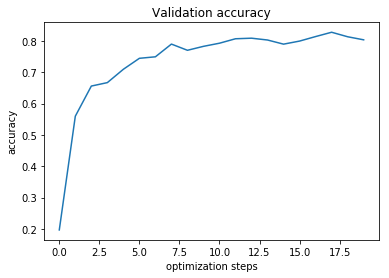

In [11]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [12]:
#to maximize accuracy
for m in model.children():
    m.reset_parameters()

#constant parameters
NUM_OPT_STEPS = 2000
batch_size = 128;

#model
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 48, kernel_size=3, stride=1)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(48, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

model = TooSimpleConvNN()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#time
t = time.time()
#training
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))

elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 19.40 19.26
   100 62.10 61.78
   200 71.40 72.26
   300 72.40 72.10
   400 77.00 77.58
   500 81.40 80.02
   600 79.50 78.16
   700 80.80 81.72
   800 83.00 81.72
   900 77.70 78.14
  1000 81.30 80.66
  1100 81.80 82.38
  1200 83.70 81.66
  1300 83.20 83.16
  1400 82.30 83.48
  1500 78.00 77.28
  1600 84.30 84.32
  1700 83.90 84.16
  1800 84.80 84.68
  1900 85.10 85.24
Total training time approx. = 551.1515917778015 secs


average accuracy =  0.76655


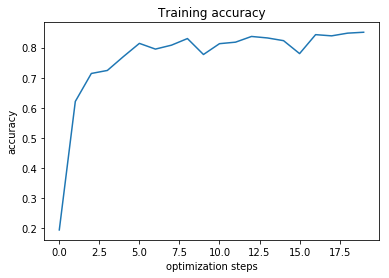

In [13]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.76488


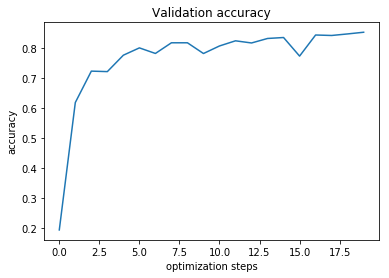

In [14]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [15]:
#to maximize accuracy
for m in model.children():
    m.reset_parameters()

#constant parameters
NUM_OPT_STEPS = 2000
batch_size = 128;

#model
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=2)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 48, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(48, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

model = TooSimpleConvNN()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#time
t = time.time()
#training
train_accs, val_accs =[], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))

elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 14.30 15.40
   100 62.10 61.76
   200 72.50 73.02
   300 77.10 77.08
   400 78.90 77.36
   500 79.00 77.28
   600 81.20 80.16
   700 78.70 78.30
   800 81.80 80.96
   900 84.30 82.34
  1000 82.70 82.50
  1100 82.20 82.30
  1200 83.70 83.24
  1300 84.80 83.58
  1400 84.40 84.00
  1500 85.80 84.78
  1600 84.50 83.80
  1700 85.30 84.74
  1800 85.40 85.54
  1900 87.10 84.48
Total training time approx. = 81.04666113853455 secs


average accuracy =  0.7779


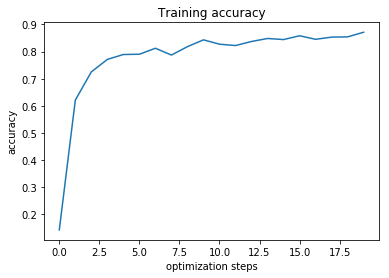

In [16]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

average accuracy =  0.77131


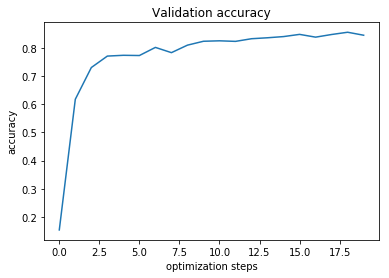

In [17]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [18]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.871 for 2000 optimization steps
Max validation accuracy= 0.8554 for 2000 optimization steps
batch_size= 128
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 81.04666113853455 secs


I feel that we are overfitting the data since i havent performed dropouts. To increase the performance further, we can imcrease the layers, add more filters and add dropouts. This is explored in 14